In [762]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn matplotlib pandas openml
# !pip install ipympl
# !pip install -U imbalanced-learn

In [763]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
import openml
import sklearn
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

# Práctica 4: Overfitting

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones. Cada función está marcada por &#x1F625;,  &#x1F643; o &#x1F921;. Las marcas indican:

- &#x1F625;: Indican una entrega que debe ser hecha dentro de la misma sesión de la asignación. 
- &#x1F643;: Indican una entrega que puede ser hecha hasta la siguiente sesión.
- &#x1F921;: Debe mostrar un avance en la misma sesión, pero la entrega puede ser hecha en la siguiente.

Aquellas entregas parciales que no sean hechas el día de la asignación ya no serán válidas para las entregas totales, sin embargo, las entregas totales seguirán siendo válidas.

En esta sección se incluye un dataset real. El dataset importado se llama LDPA y puede leer su descripción en la siguiente liga

https://www.openml.org/d/1483

In [764]:
# Descarga la metadata del dataset
dataset_info = openml.datasets.get_dataset(1483, download_data=False)

# Obtiene el nombre de la columna a predecir
target = dataset_info.default_target_attribute

(
    features, # Dataframe con las características que se pueden utilizar para predecir
    outputs, # Columna a predecir
    categorical_mask, # Máscara que indica que columnas de todas las características son categoricas
    columns # Lista con el nombre de las características
)= dataset_info.get_data(
    dataset_format="dataframe", target=target
)

categorical_mask = np.array(categorical_mask)
columns = np.array(columns)

In [765]:
print(f"La columna a predecir se llama '{target}'")
print(f"Todas las características son {str(columns)}")
print(f"Las características categóricas son {str(columns[categorical_mask])}")
print(f"Las características numéricas son {str(columns[~categorical_mask])}")

La columna a predecir se llama 'Class'
Todas las características son ['V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7']
Las características categóricas son ['V1' 'V2']
Las características numéricas son ['V3' 'V4' 'V5' 'V6' 'V7']


In [766]:
# Impresión de las características
features

,V1,V2,V3,V4,V5,V6,V7
0,1,1,105794.0,105777.0,148933.0,108479.0,109365.0
1,1,4,105795.0,105778.0,155325.0,96952.0,161363.0
2,1,3,105796.0,105779.0,156652.0,101610.0,148870.0
3,1,1,105797.0,105780.0,149736.0,107135.0,102479.0
4,1,2,105798.0,105781.0,155978.0,125455.0,106203.0
...,...,...,...,...,...,...,...
164855,5,2,43687.0,43679.0,106611.0,123166.0,12432.0
164856,5,1,43688.0,43680.0,120821.0,119848.0,87463.0
164857,5,4,43689.0,43681.0,104999.0,110823.0,161536.0
164858,5,2,43690.0,43682.0,102191.0,112520.0,10811.0


In [767]:
outputs

0         3
1         3
2         3
3         3
4         3
         ..
164855    3
164856    3
164857    3
164858    3
164859    3
Name: Class, Length: 164860, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

A continuación se realiza la partición de __train__ y __test__. __No debe utilizar la partición de test por ningún motivo__.

In [768]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    features, 
    outputs, 
    test_size=0.5, 
    random_state=11
)

## Asignación 1 &#x1F921;

Utilizando las técnicas vistas en clase, realicé su mejor esfuerzo para obtener el mejor modelo lineal posible utilizando __únicamente el conjunto de entrenamiento__ (X_train y y_train). Puede utilizar bibliotecas, pero únicamente las técnicas vistas en clase y debe ir generando métricas o visualizaciones que respalden su toma de decisiones. Debe tener e imprimir una estimación de $E_{out}$ utilizando su conjunto de entrenamiento. La métrica utilizada será la entropía cruzada.

- **V1** = {A, B, C, D, E} = 5 people
- **V2** = {ANKLE_LEFT, ANKLE_RIGHT, CHEST, BELT}
- **V3** = timestamp (Numeric) all unique
- **V4** = date FORMAT (Date)
- **V5** = x coordinate of the tag (Numeric)
- **V6** = y coordinate of the tag (Numeric)
- **V7** = z coordinate of the tag (Numeric)
- **output** = activity = {'walking', 'falling', 'lying down', 'lying', 'sitting down', 'sitting', 'standing up from lying', 'on all fours', 'sitting on the ground', 'standing up from sitting', 'standing up from sitting on the ground'} (Nominal)

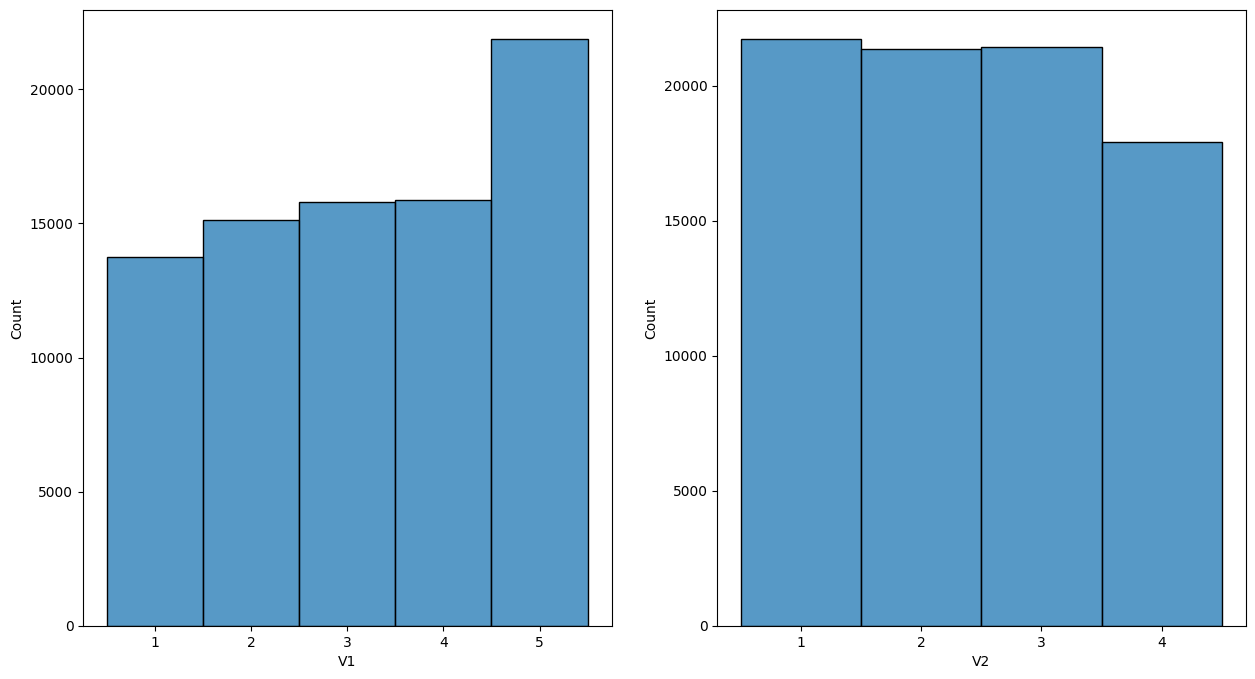

In [769]:
columns = ["V1", "V2"]
fig, axs = plt.subplots(ncols=2, nrows= 1, figsize=(15, 8))

for i, col in enumerate(columns):
    sns.histplot(data = X_train, x = col, ax = axs[i])

<Axes: xlabel='Class', ylabel='Count'>

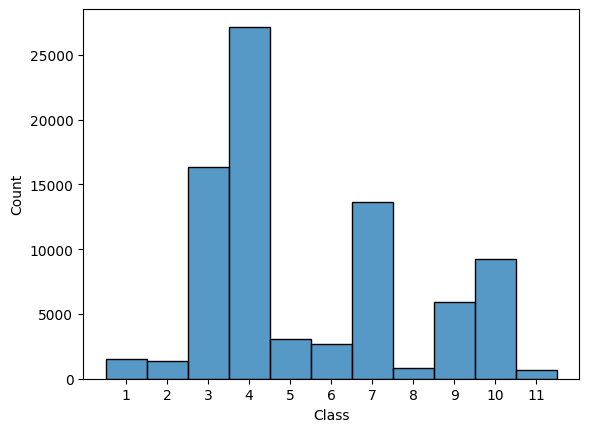

In [770]:
sns.histplot(x = y_train)

In [771]:
# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy={"3": 8000, "4": 14000, "7": 6500, "10":4000})

# fit and apply the transform
X_train, y_train = undersample.fit_resample(X_train, y_train)

<Axes: xlabel='Class', ylabel='Count'>

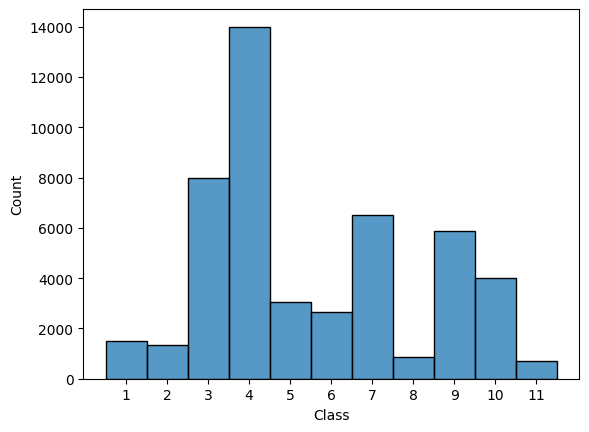

In [772]:
sns.histplot(x = y_train)

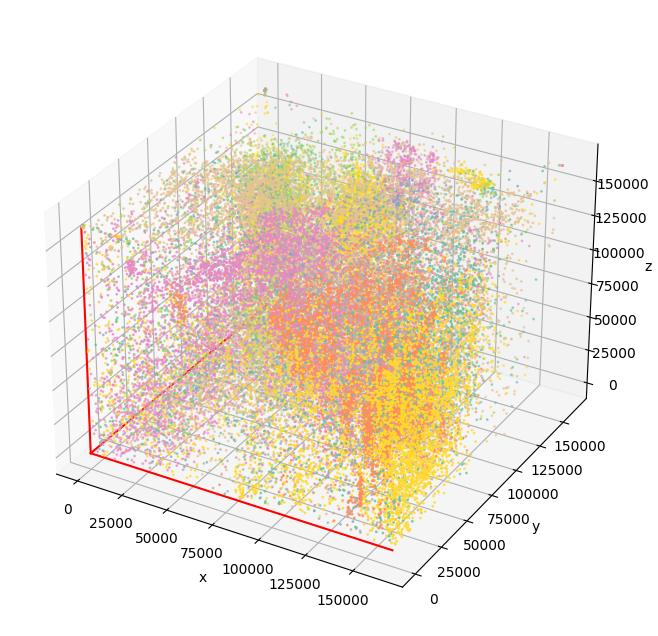

In [773]:
fig = plt.figure(figsize=(8,8))
my_color=y_train.cat.codes
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['V5'], X_train['V6'], X_train['V7'], c=my_color, cmap="Set2_r", s=1)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(X_train['V5']), max(X_train['V5'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(X_train['V6']), max(X_train['V6'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(X_train['V7']), max(X_train['V7'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

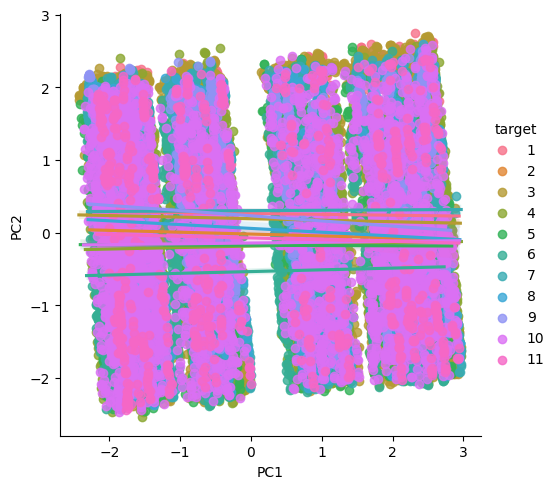

In [774]:
pca = PCA(n_components=3)

# data scaling
x_scaled = StandardScaler().fit_transform(X_train)

pca_features = pca.fit_transform(x_scaled)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2', 'PC3'])
pca_df['target'] = y_train

sns.lmplot(x='PC1',  y='PC2',  data=pca_df,  hue='target', legend=True)

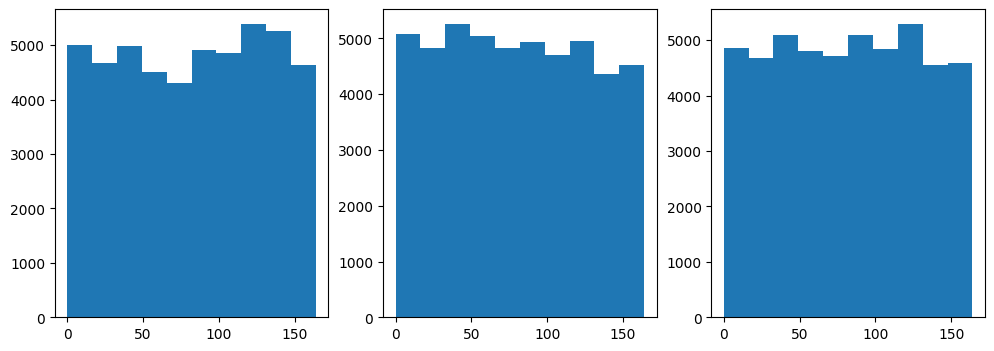

In [775]:
columns = ["V5", "V6", "V7"]
fig, axs = plt.subplots(ncols=3, nrows= 1, figsize=(12, 4))

for i, col in enumerate(columns):
    new_val = X_train[col].values
    new_val = new_val*(1/1000)
    X_train[col] = np.round(new_val)
    axs[i].hist(x = new_val.round())

In [776]:
corr_x = X_train.corr()
print(corr_x.abs().unstack().drop_duplicates().sort_values(ascending=False))

V3  V3    1.000000
    V4    1.000000
V5  V6    0.363472
V3  V5    0.089169
V4  V5    0.089167
V5  V7    0.047321
V4  V6    0.039468
V3  V6    0.039467
V4  V7    0.029957
V3  V7    0.029957
V6  V7    0.009187
dtype: float64


C:\Users\Iván\AppData\Local\Temp\ipykernel_15456\2644385476.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_x = X_train.corr()


In [777]:
X_train = X_train.drop(columns=['V3', 'V4'])
X_train

,V1,V2,V5,V6,V7
0,4,1,96.0,75.0,29.0
1,2,1,141.0,48.0,110.0
2,1,3,134.0,35.0,134.0
3,3,4,127.0,52.0,146.0
4,4,1,77.0,34.0,15.0
...,...,...,...,...,...
48502,2,3,120.0,59.0,115.0
48503,5,4,124.0,50.0,136.0
48504,4,1,81.0,112.0,35.0
48505,3,1,145.0,32.0,65.0


In [778]:
# Hacemos One Hot Encoding para V1 y V2
# X_train = pd.get_dummies(X_train, prefix=["V1","V2"], columns=["V1","V2"])
X_train

,V1,V2,V5,V6,V7
0,4,1,96.0,75.0,29.0
1,2,1,141.0,48.0,110.0
2,1,3,134.0,35.0,134.0
3,3,4,127.0,52.0,146.0
4,4,1,77.0,34.0,15.0
...,...,...,...,...,...
48502,2,3,120.0,59.0,115.0
48503,5,4,124.0,50.0,136.0
48504,4,1,81.0,112.0,35.0
48505,3,1,145.0,32.0,65.0


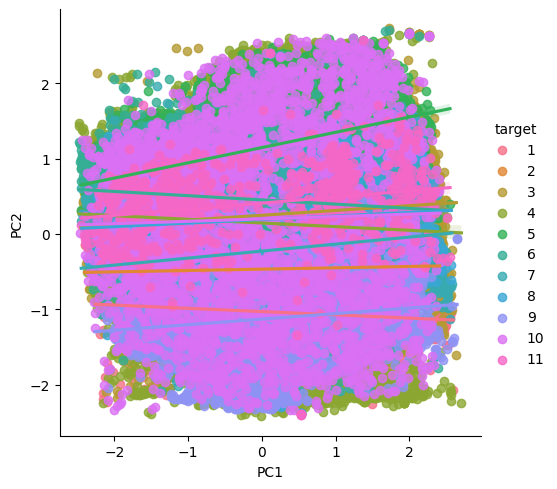

In [779]:
pca = PCA(n_components=3)

# data scaling
x_scaled = StandardScaler().fit_transform(X_train) 
# x_scaled = StandardScaler().fit_transform(features) 

pca_features = pca.fit_transform(x_scaled)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2', 'PC3'])
pca_df['target'] = y_train

sns.lmplot(x='PC1',  y='PC2',  data=pca_df,  hue='target', legend=True)

In [780]:
preprocess_minmax = make_column_transformer(
    (MinMaxScaler(), ['V5', 'V6', 'V7']),
    (OneHotEncoder(), ['V1', 'V2'])
)

pipe = Pipeline(steps=[
    ('preprocess', preprocess_minmax),
    ('model_LR', LogisticRegression(solver="sag", multi_class='multinomial'))
])

scores_LR = cross_val_score(pipe, X_train, y_train, cv=16)
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores_LR.mean(), scores_LR.std()))

0.3508 accuracy with a standard deviation of 0.0067


In [781]:
pipe.fit(X_train, y_train)
# pipe.score(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['V5', 'V6', 'V7']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['V1', 'V2'])])),
                ('model_LR',
                 LogisticRegression(multi_class='multinomial', solver='sag'))])

In [788]:
pipe.transform(X_test)

AttributeError: This 'Pipeline' has no attribute 'transform'

In [782]:
pipe.score(X_test, y_test)

0.044680334829552346

In [783]:
model_SGD = make_pipeline(StandardScaler(), SGDClassifier(loss='log_loss', penalty='l1'))
scores_SGD = cross_val_score(model_SGD, X_train, y_train, cv=16)
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores_SGD.mean(), scores_SGD.std()))

0.3522 accuracy with a standard deviation of 0.0079


In [784]:
model_SGD = make_pipeline(StandardScaler(), SGDClassifier(loss='perceptron', penalty='l1'))
scores_SGD = cross_val_score(model_SGD, X_train, y_train, cv=16)
print("%0.4f accuracy with a standard deviation of %0.4f" % (scores_SGD.mean(), scores_SGD.std()))

0.1991 accuracy with a standard deviation of 0.0497


In [785]:
model = make_pipeline(MinMaxScaler(), LogisticRegression(solver="sag", multi_class='multinomial'))
model = model.fit(X_train, y_train)

print("%0.4f accuracy" % model.score(X_train, y_train))

0.3512 accuracy


In [786]:
def scaled_dataframe(data):
    data_scaled = data
    for i in data.columns:
        if data[i].dtype == 'int64' or data[i].dtype == 'float64':
            min_r = np.amin(data[i])
            max_r = np.amax(data[i])

            data_scaled[i] = (data[i]-min_r)/(max_r-min_r)

    return data_scaled

In [787]:
X_train = scaled_dataframe(X_train)
model = LogisticRegression(solver="sag", multi_class='multinomial')
model = model.fit(X_train, y_train)

print("%0.4f accuracy" % model.score(X_train, y_train))

TypeError: can't multiply sequence by non-int of type 'float'

## Asignación 2 &#x1F921;

Evalue su modelo final en el conjunto de test (X_test y y_test). Su práctica será evaluada acorde a las técnicas aplicadas, la estimación de $E_{out}$, el valor de $E_{test}$, y contra las métricas obtenidas por sus compañeros.

In [ ]:
def scaled_dataframe(data):
    data_scaled = data
    for i in data.columns:
        if data[i].dtype == 'int64' or data[i].dtype == 'float64':
            min_r = np.amin(data[i])
            max_r = np.amax(data[i])

            data_scaled[i] = (data[i]-min_r)/(max_r-min_r)

    return data_scaled

In [ ]:
X_test = pd.get_dummies(X_test, prefix=["V1","V2"], columns=["V1","V2"])
X_test = X_test.drop(columns=['V3', 'V4'])

X_test = scaled_dataframe(X_test)
X_test

,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
9783,0.551893,0.110488,0.740631,1,0,0,0,0,0,0,0,1
85013,0.034487,0.904584,0.394811,0,0,1,0,0,0,0,0,1
70883,0.166508,0.616167,0.702954,0,0,1,0,0,1,0,0,0
64466,0.108150,0.390706,0.068819,0,0,1,0,0,0,1,0,0
82448,0.002424,0.988728,0.997082,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
102897,0.396319,0.337793,0.418006,0,0,0,1,0,1,0,0,0
40732,0.209603,0.193985,0.438459,0,1,0,0,0,0,1,0,0
114945,0.144371,0.230592,0.814192,0,0,0,1,0,0,0,1,0
19389,0.751392,0.110091,0.546481,1,0,0,0,0,0,1,0,0


<Axes: ylabel='Count'>

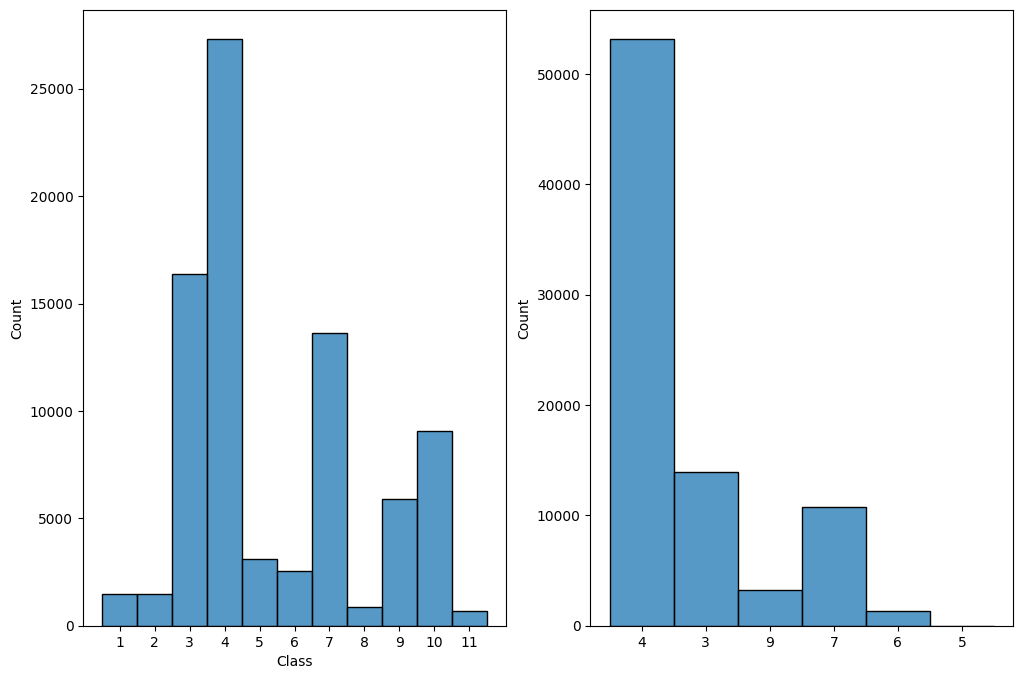

In [ ]:
y_pred = model.predict(X_test)
fig, axs = plt.subplots(ncols=2, nrows= 1, figsize=(12, 8))
sns.histplot(x = y_test, ax = axs[0])
sns.histplot(x = y_pred, ax = axs[1])

In [ ]:
model.score(X_test, y_test)

0.39450442799951474